In [1]:
import torch
# GPU 사용 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
print(torch.cuda.get_device_name(0))

# CUDA 사용 가능 여부 확인
print(f"CUDA available: {torch.cuda.is_available()}")  # True여야 함

# PyTorch에서 사용하는 CUDA 버전 확인
print(f"CUDA version in PyTorch: {torch.version.cuda}")

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cuda
NVIDIA GeForce RTX 4050 Laptop GPU
CUDA available: True
CUDA version in PyTorch: 11.8


In [2]:
# 라이브러리 임포트
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import albumentations as A
import matplotlib.pyplot as plt
import torch.nn.functional as F

d:\isy\test\Lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
import torch
import cv2
import numpy as np
import os
import random
from torchvision import models, transforms

# ResNet 및 Inception 모델 수정
class CustomModel(torch.nn.Module):
    def __init__(self, model_name):
        super(CustomModel, self).__init__()
        if model_name == 'efficientnet':
            self.model = models.efficientnet_b2(weights='IMAGENET1K_V1') 
            self.model.classifier[1] = torch.nn.Linear(self.model.classifier[1].in_features, 1)  # 이진 분류
        
    def forward(self, x):
        return self.model(x)

# efficientnet 모델 로드
efficientnet_model = CustomModel(model_name='efficientnet')
efficientnet_model.eval()  # 평가 모드로 설정

# 전처리 파이프라인 정의
preprocess = transforms.Compose([
    transforms.ToPILImage(),  # OpenCV 이미지를 PIL 이미지로 변환
    transforms.Resize((260, 260)),  # 모델 입력 크기에 맞게 크기 조정
    transforms.ToTensor(),  # 텐서로 변환
])

# 이미지 전처리 함수
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # RGB로 변환
    image = preprocess(image)  # 전처리 적용
    image = image.unsqueeze(0)  # 배치 차원 추가
    return image

# 예측 함수 정의
def predict_image(model, image_path, device):
    model.to(DEVICE)  # 모델을 디바이스로 이동
    image = preprocess_image(image_path).to(device)  # 전처리 후 디바이스로 이동
    with torch.no_grad():  # 평가 모드에서는 gradient 계산 비활성화
        output = model(image)
        predicted_prob = torch.sigmoid(output).item()  # 확률로 변환

    # 0.5를 기준으로 정상/비정상 예측
    prediction = 'NG (결함 있음)' if predicted_prob > 0.5 else 'OK (정상)'
    return prediction, predicted_prob

# NG 폴더 경로
ng_folder_path = '../PCB_imgs/all/resize/NG/' 
# OK 폴더 경로
ok_folder_path = '../PCB_imgs/all/resize/OK/' 
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # 디바이스 설정

# 각 폴더에서 무작위로 10개의 이미지를 가져오기
def load_random_images(folder_path, num_images=10):
    images = os.listdir(folder_path)
    random_images = random.sample(images, min(num_images, len(images)))
    return [os.path.join(folder_path, img) for img in random_images]

# NG 및 OK 이미지 로드
ng_images = load_random_images(ng_folder_path)
ok_images = load_random_images(ok_folder_path)

# NG 이미지 예측 결과와 확률
print(f'NG 예측결과:')
for image_path in ng_images:
    prediction, prob = predict_image(efficientnet_model, image_path, DEVICE) 
    print(f"Efficientnet: {prediction}, 확률: {prob:.4f}")

# OK 이미지 예측 결과와 확률
print(f'OK 예측결과:')
for image_path in ok_images:
    prediction, prob = predict_image(efficientnet_model, image_path, DEVICE) 
    print(f"Efficientnet: {prediction}, 확률: {prob:.4f}")

NG 예측결과:
Efficientnet: OK (정상), 확률: 0.4919
Efficientnet: NG (결함 있음), 확률: 0.5310
Efficientnet: NG (결함 있음), 확률: 0.5072
Efficientnet: OK (정상), 확률: 0.5000
Efficientnet: NG (결함 있음), 확률: 0.5188
Efficientnet: OK (정상), 확률: 0.4762
Efficientnet: NG (결함 있음), 확률: 0.5247
Efficientnet: NG (결함 있음), 확률: 0.5062
Efficientnet: NG (결함 있음), 확률: 0.5311
Efficientnet: OK (정상), 확률: 0.4719
OK 예측결과:
Efficientnet: NG (결함 있음), 확률: 0.6040
Efficientnet: NG (결함 있음), 확률: 0.5677
Efficientnet: NG (결함 있음), 확률: 0.5071
Efficientnet: OK (정상), 확률: 0.4711
Efficientnet: NG (결함 있음), 확률: 0.5034
Efficientnet: OK (정상), 확률: 0.4977
Efficientnet: OK (정상), 확률: 0.4961
Efficientnet: NG (결함 있음), 확률: 0.5232
Efficientnet: NG (결함 있음), 확률: 0.5397
Efficientnet: NG (결함 있음), 확률: 0.5410


In [3]:
from torchvision import datasets
import pandas as pd

IMAGE_SIZE = 260
BATCH_SIZE = 32
EPOCHS = 10

# 이미지 변환 정의
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),  # 이미지를 Tensor로 변환 (0~255 범위를 0~1 범위로 정규화)
])

# 데이터셋 디렉토리 설정
train_dir = '../PCB_imgs/all/resize/train'
val_dir = '../PCB_imgs/all/resize/validation'
test_dir = '../PCB_imgs/all/resize/test'

# ImageFolder로 데이터셋 불러오기
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# 파일 경로 및 타겟 추출
train_file_paths = [img[0] for img in train_dataset.imgs]
train_targets = train_dataset.targets

val_file_paths = [img[0] for img in val_dataset.imgs]
val_targets = val_dataset.targets

test_file_paths = [img[0] for img in test_dataset.imgs]
test_targets = test_dataset.targets

# DataFrame 생성
train_df = pd.DataFrame({'file_paths': train_file_paths, 'targets': train_targets})
validation_df = pd.DataFrame({'file_paths': val_file_paths, 'targets': val_targets})
test_df = pd.DataFrame({'file_paths': test_file_paths, 'targets': test_targets})

# 확인을 위해 각 데이터셋의 크기 출력
print(f"Train 데이터 수: {len(train_df)}")
print(f"Validation 데이터 수: {len(validation_df)}")
print(f"Test 데이터 수: {len(test_df)}")

Train 데이터 수: 2008
Validation 데이터 수: 502
Test 데이터 수: 628


In [4]:
import torch
from torchvision import datasets, transforms

# resize된 데이터셋 로드
input_dir = '../PCB_imgs/all/resize/'
dataset = datasets.ImageFolder(root=input_dir, transform=transform)

# 데이터 로더 정의
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# 데이터 로더에서 데이터 가져오기
for images, labels in dataloader:
    print(images.shape)  # 배치의 이미지 텐서 크기 확인
    break  # 첫 번째 배치만 확인
    # 배치 크기, 채널 수(RGB), 이미지 크기 

torch.Size([32, 3, 260, 260])


In [5]:
# 커스텀 데이터세트 정의
class CustomDataset(Dataset):
    def __init__(self, file_paths, targets, aug=None, preprocess=None):
        self.file_paths = file_paths
        self.targets = targets
        self.aug = aug
        self.preprocess = preprocess

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        file_path = self.file_paths[index]
        target = self.targets[index]
        
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))

        if self.aug is not None:
            image = self.aug(image=image)['image']

        if self.preprocess is not None:
            image = self.preprocess(image)

        image = np.transpose(image, (2, 0, 1))  # (H, W, C) -> (C, H, W)
        image = torch.tensor(image, dtype=torch.float32)
        
        return image, target, file_path

In [8]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader

# 데이터셋 인스턴스 생성
train_dataset = CustomDataset(train_df['file_paths'].values, train_df['targets'].values)
validation_dataset = CustomDataset(validation_df['file_paths'].values, validation_df['targets'].values)
test_dataset = CustomDataset(test_df['file_paths'].values, test_df['targets'].values)

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [6]:
# 평가 함수 정의
def evaluate_model(model, test_loader, criterion):
    model.eval()
    running_test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float()
            outputs = model(images)
            outputs = outputs.view(-1) # torch.Size([batch_size])로 변환
            loss = criterion(outputs, labels)  # 손실 계산
            running_test_loss += loss.item()
            
            predicted = (torch.sigmoid(outputs) > 0.5).float()  # 0.5 기준으로 이진 분류
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            
    # 검증 손실과 정확도
    test_loss = running_test_loss / len(test_loader)
    test_accuracy = correct_test / total_test
    return test_loss, test_accuracy

efficientnet_b2 모델 사용

In [19]:
class CustomModel(nn.Module):
    def __init__(self, model_name='efficientnet'):
        super(CustomModel, self).__init__()
        if model_name == 'efficientnet':
            self.base_model = torchvision.models.efficientnet_b2(weights='IMAGENET1K_V1')
            self.base_model.classifier = nn.Identity()  # 마지막 분류기 제거
        elif model_name == 'resnet50':
            self.base_model = torchvision.models.resnet50(weights='IMAGENET1K_V1')
            self.base_model = nn.Sequential(*list(self.base_model.children())[:-1])  # 마지막 레이어 제거
        elif model_name == 'inception':
            self.base_model = torchvision.models.inception_v3(weights='IMAGENET1K_V1')
            self.base_model.classifier = nn.Identity()  # 마지막 분류기 제거

        self.dropout1 = nn.Dropout(0.5)  # 첫 번째 드롭아웃
        self.fc1 = nn.Linear(self._get_features_dim(model_name), 50)
        self.bn1 = nn.BatchNorm1d(50)
        self.relu = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)  # 두 번째 드롭아웃
        self.fc2 = nn.Linear(50, 1)

    def _get_features_dim(self, model_name):
        if model_name == 'efficientnet':
            return 1408  # EfficientNet B2의 출력 차원
        elif model_name == 'resnet50':
            return 2048  # ResNet50의 출력 차원
        elif model_name == 'inception':
            return 2048  # Inception의 출력 차원

    def forward(self, x):
        x = self.base_model(x)
        if isinstance(x, tuple):  
            x = x[0]
        x = x.view(x.size(0), -1)  

        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x) 
        x = self.bn1(x) 
        x = self.dropout2(x) 
        x = self.fc2(x)
        
        return x

In [7]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader

# 데이터 증강 정의
aug = A.Compose([
    A.HorizontalFlip(p=0.5),                # 좌우 반전
    A.VerticalFlip(p=0.5),                  # 상하 반전
    A.Rotate(limit=10, p=0.5),              # 작은 각도 회전 (10도 내외)
    A.RandomBrightnessContrast(p=0.5),      # 밝기 및 대비 조절
])

# 데이터셋 인스턴스 생성
train_dataset = CustomDataset(train_df['file_paths'].values, train_df['targets'].values, aug=aug)
validation_dataset = CustomDataset(validation_df['file_paths'].values, validation_df['targets'].values)
test_dataset = CustomDataset(test_df['file_paths'].values, test_df['targets'].values)

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [21]:
# 모델 생성
model = CustomModel(model_name='efficientnet').to(DEVICE)

# 1. 사전 학습된 base_model의 파라미터를 동결 (fine-tuning 초기 단계)
for param in model.base_model.parameters():
    param.requires_grad = False

# 마지막 몇 개의 레이어를 동결 해제 (features 블록 5 이후 층)
for name, param in model.base_model.features[5:].named_parameters():
    param.requires_grad = True

# 동결 해제된 일부 층과 분류기 층 학습
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-5)

# 학습할 손실 함수
criterion = nn.BCEWithLogitsLoss()

# 각 층의 freeze/unfreeze 상태 확인
for name, param in model.named_parameters():
    print(f"Layer: {name} | Requires Grad: {param.requires_grad}")

Layer: base_model.features.0.0.weight | Requires Grad: False
Layer: base_model.features.0.1.weight | Requires Grad: False
Layer: base_model.features.0.1.bias | Requires Grad: False
Layer: base_model.features.1.0.block.0.0.weight | Requires Grad: False
Layer: base_model.features.1.0.block.0.1.weight | Requires Grad: False
Layer: base_model.features.1.0.block.0.1.bias | Requires Grad: False
Layer: base_model.features.1.0.block.1.fc1.weight | Requires Grad: False
Layer: base_model.features.1.0.block.1.fc1.bias | Requires Grad: False
Layer: base_model.features.1.0.block.1.fc2.weight | Requires Grad: False
Layer: base_model.features.1.0.block.1.fc2.bias | Requires Grad: False
Layer: base_model.features.1.0.block.2.0.weight | Requires Grad: False
Layer: base_model.features.1.0.block.2.1.weight | Requires Grad: False
Layer: base_model.features.1.0.block.2.1.bias | Requires Grad: False
Layer: base_model.features.1.1.block.0.0.weight | Requires Grad: False
Layer: base_model.features.1.1.block.0

In [22]:
EPOCHS = 50

# 조기 종료 변수 초기화
best_val_loss = float('inf')
patience = 5  # 개선이 없을 때 기다릴 에포크 수
patience_counter = 0

# 학습률 스케줄러
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, targets in train_loader:
        images, targets = images.to(DEVICE), targets.to(DEVICE).float()
        
        optimizer.zero_grad()
        outputs = model(images)

        # 손실 계산
        loss = criterion(outputs.view(-1), targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # 정확도 계산
        predicted = (torch.sigmoid(outputs.view(-1)) > 0.5).float()
        correct_predictions += (predicted == targets).sum().item()
        total_predictions += targets.size(0)

    # 훈련 데이터 정확도
    train_accuracy = correct_predictions / total_predictions

    # 검증
    val_loss, val_accuracy = evaluate_model(model, validation_loader, criterion)

    # 학습률 스케줄러 적용
    scheduler.step(val_loss)

    # 현재 학습률 출력
    current_lr = optimizer.param_groups[0]['lr']

    # 조기 종료 로직
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # 손실 개선 시 카운터 리셋
        print("Validation loss improved, saving model...")
        # 모델 저장
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
        }, '../model/efficientnet_b2_ft_best_model_01.pth')
    else:
        patience_counter += 1  # 손실이 개선되지 않으면 카운터 증가

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break  # 훈련 종료

    # 에포크별 정보 출력 (학습률 포함)
    print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {running_loss / len(train_loader):.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, '
          f'Learning Rate: {current_lr:.6f}')

Validation loss improved, saving model...
Epoch [1/50], Train Loss: 0.6642, Train Accuracy: 0.5901, Val Loss: 0.4841, Val Accuracy: 0.8108, Learning Rate: 0.000050
Validation loss improved, saving model...
Epoch [2/50], Train Loss: 0.5080, Train Accuracy: 0.7560, Val Loss: 0.4435, Val Accuracy: 0.7988, Learning Rate: 0.000050
Validation loss improved, saving model...
Epoch [3/50], Train Loss: 0.4769, Train Accuracy: 0.7744, Val Loss: 0.3968, Val Accuracy: 0.8406, Learning Rate: 0.000050
Validation loss improved, saving model...
Epoch [4/50], Train Loss: 0.4317, Train Accuracy: 0.8142, Val Loss: 0.3786, Val Accuracy: 0.8466, Learning Rate: 0.000050
Validation loss improved, saving model...
Epoch [5/50], Train Loss: 0.4008, Train Accuracy: 0.8302, Val Loss: 0.3494, Val Accuracy: 0.8805, Learning Rate: 0.000050
Validation loss improved, saving model...
Epoch [6/50], Train Loss: 0.3789, Train Accuracy: 0.8461, Val Loss: 0.3272, Val Accuracy: 0.8865, Learning Rate: 0.000050
Validation loss 

In [23]:
model = CustomModel('efficientnet').to(DEVICE)

checkpoint = torch.load('../model/efficientnet_b2_ft_best_model_01.pth')

model.load_state_dict(checkpoint['model_state_dict'])

for param in model.base_model.parameters():
    param.requires_grad = False

# 마지막 몇 개의 레이어를 동결 해제 (features 블록 5 이후 층)
for name, param in model.base_model.features[5:].named_parameters():
    param.requires_grad = True

# 동결 해제된 일부 층과 분류기 층 학습
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-5)

model.eval()

C:\Users\enssel\AppData\Local\Temp\ipykernel_4440\457214973.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../model/efficientnet_b2_ft_best_mod

CustomModel(
  (base_model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scal

In [24]:
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}')

Test loss: 0.1010, Test accuracy: 0.9697


적은 연산량으로 좋은 성능을 낼수있는 모델임.  
feature 8 ~ unfreeze 

In [25]:
class CustomModel(nn.Module):
    def __init__(self, model_name='efficientnet'):
        super(CustomModel, self).__init__()
        if model_name == 'efficientnet':
            self.base_model = torchvision.models.efficientnet_b2(weights='IMAGENET1K_V1')
            self.base_model.classifier = nn.Identity()  # 마지막 분류기 제거
        elif model_name == 'resnet50':
            self.base_model = torchvision.models.resnet50(weights='IMAGENET1K_V1')
            self.base_model = nn.Sequential(*list(self.base_model.children())[:-1])  # 마지막 레이어 제거
        elif model_name == 'inception':
            self.base_model = torchvision.models.inception_v3(weights='IMAGENET1K_V1')
            self.base_model.classifier = nn.Identity()  # 마지막 분류기 제거

        self.dropout1 = nn.Dropout(0.5)  # 첫 번째 드롭아웃
        self.fc1 = nn.Linear(self._get_features_dim(model_name), 50)
        self.bn1 = nn.BatchNorm1d(50)
        self.relu = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)  # 두 번째 드롭아웃
        self.fc2 = nn.Linear(50, 1)

    def _get_features_dim(self, model_name):
        if model_name == 'efficientnet':
            return 1408  # EfficientNet B2의 출력 차원
        elif model_name == 'resnet50':
            return 2048  # ResNet50의 출력 차원
        elif model_name == 'inception':
            return 2048  # Inception의 출력 차원

    def forward(self, x):
        x = self.base_model(x)
        if isinstance(x, tuple):  
            x = x[0]
        x = x.view(x.size(0), -1)  

        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x) 
        x = self.bn1(x) 
        x = self.dropout2(x) 
        x = self.fc2(x)
        
        return x

In [26]:
# 모델 생성
model = CustomModel(model_name='efficientnet').to(DEVICE)

# 1. 사전 학습된 base_model의 파라미터를 동결 (fine-tuning 초기 단계)
for param in model.base_model.parameters():
    param.requires_grad = False

# 마지막 몇 개의 레이어를 동결 해제 (features 블록 8 이후 층)
for name, param in model.base_model.features[8:].named_parameters():
    param.requires_grad = True

# 동결 해제된 일부 층과 분류기 층 학습
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-5)

# 학습할 손실 함수
criterion = nn.BCEWithLogitsLoss()

# 각 층의 freeze/unfreeze 상태 확인
for name, param in model.named_parameters():
    print(f"Layer: {name} | Requires Grad: {param.requires_grad}")

Layer: base_model.features.0.0.weight | Requires Grad: False
Layer: base_model.features.0.1.weight | Requires Grad: False
Layer: base_model.features.0.1.bias | Requires Grad: False
Layer: base_model.features.1.0.block.0.0.weight | Requires Grad: False
Layer: base_model.features.1.0.block.0.1.weight | Requires Grad: False
Layer: base_model.features.1.0.block.0.1.bias | Requires Grad: False
Layer: base_model.features.1.0.block.1.fc1.weight | Requires Grad: False
Layer: base_model.features.1.0.block.1.fc1.bias | Requires Grad: False
Layer: base_model.features.1.0.block.1.fc2.weight | Requires Grad: False
Layer: base_model.features.1.0.block.1.fc2.bias | Requires Grad: False
Layer: base_model.features.1.0.block.2.0.weight | Requires Grad: False
Layer: base_model.features.1.0.block.2.1.weight | Requires Grad: False
Layer: base_model.features.1.0.block.2.1.bias | Requires Grad: False
Layer: base_model.features.1.1.block.0.0.weight | Requires Grad: False
Layer: base_model.features.1.1.block.0

In [27]:
EPOCHS = 50

# 조기 종료 변수 초기화
best_val_loss = float('inf')
patience = 5  # 개선이 없을 때 기다릴 에포크 수
patience_counter = 0

# 학습률 스케줄러
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, targets in train_loader:
        images, targets = images.to(DEVICE), targets.to(DEVICE).float()
        
        optimizer.zero_grad()
        outputs = model(images)

        # 손실 계산
        loss = criterion(outputs.view(-1), targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # 정확도 계산
        predicted = (torch.sigmoid(outputs.view(-1)) > 0.5).float()
        correct_predictions += (predicted == targets).sum().item()
        total_predictions += targets.size(0)

    # 훈련 데이터 정확도
    train_accuracy = correct_predictions / total_predictions

    # 검증
    val_loss, val_accuracy = evaluate_model(model, validation_loader, criterion)

    # 학습률 스케줄러 적용
    scheduler.step(val_loss)

    # 현재 학습률 출력
    current_lr = optimizer.param_groups[0]['lr']

    # 조기 종료 로직
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # 손실 개선 시 카운터 리셋
        print("Validation loss improved, saving model...")
        # 모델 저장
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
        }, '../model/efficientnet_b2_ft_best_model_02.pth')
    else:
        patience_counter += 1  # 손실이 개선되지 않으면 카운터 증가

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break  # 훈련 종료

    # 에포크별 정보 출력 (학습률 포함)
    print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {running_loss / len(train_loader):.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, '
          f'Learning Rate: {current_lr:.6f}')

Validation loss improved, saving model...
Epoch [1/50], Train Loss: 0.6941, Train Accuracy: 0.5702, Val Loss: 0.5888, Val Accuracy: 0.6793, Learning Rate: 0.000050
Validation loss improved, saving model...
Epoch [2/50], Train Loss: 0.5934, Train Accuracy: 0.6788, Val Loss: 0.5236, Val Accuracy: 0.7709, Learning Rate: 0.000050
Validation loss improved, saving model...
Epoch [3/50], Train Loss: 0.5673, Train Accuracy: 0.6987, Val Loss: 0.4936, Val Accuracy: 0.7809, Learning Rate: 0.000050
Validation loss improved, saving model...
Epoch [4/50], Train Loss: 0.5349, Train Accuracy: 0.7186, Val Loss: 0.4731, Val Accuracy: 0.7948, Learning Rate: 0.000050
Validation loss improved, saving model...
Epoch [5/50], Train Loss: 0.5246, Train Accuracy: 0.7390, Val Loss: 0.4497, Val Accuracy: 0.8127, Learning Rate: 0.000050
Validation loss improved, saving model...
Epoch [6/50], Train Loss: 0.4882, Train Accuracy: 0.7694, Val Loss: 0.4372, Val Accuracy: 0.8207, Learning Rate: 0.000050
Validation loss 

In [42]:
model = CustomModel('efficientnet').to(DEVICE)

checkpoint = torch.load('../model/efficientnet_b2_ft_best_model_02.pth')

model.load_state_dict(checkpoint['model_state_dict'])

for param in model.base_model.parameters():
    param.requires_grad = False

# 마지막 몇 개의 레이어를 동결 해제 (features 블록 8 이후 층)
for name, param in model.base_model.features[8:].named_parameters():
    param.requires_grad = True

# 동결 해제된 일부 층과 분류기 층 학습
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-5)

model.eval()

C:\Users\enssel\AppData\Local\Temp\ipykernel_4440\3716248305.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../model/efficientnet_b2_ft_best_mo

CustomModel(
  (base_model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scal

In [43]:
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}')

Test loss: 0.2437, Test accuracy: 0.9156


추가 50 epoch

In [44]:
EPOCHS = 50

# 조기 종료 변수 초기화
best_val_loss = float('inf')
patience = 5  # 개선이 없을 때 기다릴 에포크 수
patience_counter = 0

# 학습률 스케줄러
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, targets in train_loader:
        images, targets = images.to(DEVICE), targets.to(DEVICE).float()
        
        optimizer.zero_grad()
        outputs = model(images)

        # 손실 계산
        loss = criterion(outputs.view(-1), targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # 정확도 계산
        predicted = (torch.sigmoid(outputs.view(-1)) > 0.5).float()
        correct_predictions += (predicted == targets).sum().item()
        total_predictions += targets.size(0)

    # 훈련 데이터 정확도
    train_accuracy = correct_predictions / total_predictions

    # 검증
    val_loss, val_accuracy = evaluate_model(model, validation_loader, criterion)

    # 학습률 스케줄러 적용
    scheduler.step(val_loss)

    # 현재 학습률 출력
    current_lr = optimizer.param_groups[0]['lr']

    # 조기 종료 로직
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # 손실 개선 시 카운터 리셋
        print("Validation loss improved, saving model...")
        # 모델 저장
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
        }, '../model/efficientnet_b2_ft_best_model_02.pth')
    else:
        patience_counter += 1  # 손실이 개선되지 않으면 카운터 증가

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break  # 훈련 종료

    # 에포크별 정보 출력 (학습률 포함)
    print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {running_loss / len(train_loader):.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, '
          f'Learning Rate: {current_lr:.6f}')

Validation loss improved, saving model...
Epoch [1/50], Train Loss: 0.2727, Train Accuracy: 0.8954, Val Loss: 0.2674, Val Accuracy: 0.8964, Learning Rate: 0.000050
Epoch [2/50], Train Loss: 0.2755, Train Accuracy: 0.8979, Val Loss: 0.2704, Val Accuracy: 0.8924, Learning Rate: 0.000050
Epoch [3/50], Train Loss: 0.2723, Train Accuracy: 0.8840, Val Loss: 0.2731, Val Accuracy: 0.8825, Learning Rate: 0.000050
Validation loss improved, saving model...
Epoch [4/50], Train Loss: 0.2717, Train Accuracy: 0.8954, Val Loss: 0.2598, Val Accuracy: 0.9004, Learning Rate: 0.000050
Epoch [5/50], Train Loss: 0.2662, Train Accuracy: 0.8989, Val Loss: 0.2612, Val Accuracy: 0.8884, Learning Rate: 0.000050
Validation loss improved, saving model...
Epoch [6/50], Train Loss: 0.2484, Train Accuracy: 0.9004, Val Loss: 0.2572, Val Accuracy: 0.8884, Learning Rate: 0.000050
Validation loss improved, saving model...
Epoch [7/50], Train Loss: 0.2463, Train Accuracy: 0.9034, Val Loss: 0.2562, Val Accuracy: 0.8924, Le

학습률 조정 (더 작게)5e-5 -> 1e-5, features.5~unfreeze

In [30]:
# 모델 생성
model = CustomModel(model_name='efficientnet').to(DEVICE)

# 1. 사전 학습된 base_model의 파라미터를 동결 (fine-tuning 초기 단계)
for param in model.base_model.parameters():
    param.requires_grad = False

# 마지막 몇 개의 레이어를 동결 해제 (features 블록 5 이후 층)
for name, param in model.base_model.features[5:].named_parameters():
    param.requires_grad = True

# 동결 해제된 일부 층과 분류기 층 학습
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)

# 학습할 손실 함수
criterion = nn.BCEWithLogitsLoss()

# 각 층의 freeze/unfreeze 상태 확인
for name, param in model.named_parameters():
    print(f"Layer: {name} | Requires Grad: {param.requires_grad}")

Layer: base_model.features.0.0.weight | Requires Grad: False
Layer: base_model.features.0.1.weight | Requires Grad: False
Layer: base_model.features.0.1.bias | Requires Grad: False
Layer: base_model.features.1.0.block.0.0.weight | Requires Grad: False
Layer: base_model.features.1.0.block.0.1.weight | Requires Grad: False
Layer: base_model.features.1.0.block.0.1.bias | Requires Grad: False
Layer: base_model.features.1.0.block.1.fc1.weight | Requires Grad: False
Layer: base_model.features.1.0.block.1.fc1.bias | Requires Grad: False
Layer: base_model.features.1.0.block.1.fc2.weight | Requires Grad: False
Layer: base_model.features.1.0.block.1.fc2.bias | Requires Grad: False
Layer: base_model.features.1.0.block.2.0.weight | Requires Grad: False
Layer: base_model.features.1.0.block.2.1.weight | Requires Grad: False
Layer: base_model.features.1.0.block.2.1.bias | Requires Grad: False
Layer: base_model.features.1.1.block.0.0.weight | Requires Grad: False
Layer: base_model.features.1.1.block.0

In [31]:
EPOCHS = 50

# 조기 종료 변수 초기화
best_val_loss = float('inf')
patience = 5  # 개선이 없을 때 기다릴 에포크 수
patience_counter = 0

# 학습률 스케줄러
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, targets in train_loader:
        images, targets = images.to(DEVICE), targets.to(DEVICE).float()
        
        optimizer.zero_grad()
        outputs = model(images)

        # 손실 계산
        loss = criterion(outputs.view(-1), targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # 정확도 계산
        predicted = (torch.sigmoid(outputs.view(-1)) > 0.5).float()
        correct_predictions += (predicted == targets).sum().item()
        total_predictions += targets.size(0)

    # 훈련 데이터 정확도
    train_accuracy = correct_predictions / total_predictions

    # 검증
    val_loss, val_accuracy = evaluate_model(model, validation_loader, criterion)

    # 학습률 스케줄러 적용
    scheduler.step(val_loss)

    # 현재 학습률 출력
    current_lr = optimizer.param_groups[0]['lr']

    # 조기 종료 로직
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # 손실 개선 시 카운터 리셋
        print("Validation loss improved, saving model...")
        # 모델 저장
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
        }, '../model/efficientnet_b2_ft_best_model_03.pth')
    else:
        patience_counter += 1  # 손실이 개선되지 않으면 카운터 증가

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break  # 훈련 종료

    # 에포크별 정보 출력 (학습률 포함)
    print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {running_loss / len(train_loader):.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, '
          f'Learning Rate: {current_lr:.6f}')

Validation loss improved, saving model...
Epoch [1/50], Train Loss: 0.7188, Train Accuracy: 0.5443, Val Loss: 0.6469, Val Accuracy: 0.6394, Learning Rate: 0.000010
Validation loss improved, saving model...
Epoch [2/50], Train Loss: 0.6705, Train Accuracy: 0.5976, Val Loss: 0.5931, Val Accuracy: 0.7092, Learning Rate: 0.000010
Validation loss improved, saving model...
Epoch [3/50], Train Loss: 0.6252, Train Accuracy: 0.6579, Val Loss: 0.5557, Val Accuracy: 0.7410, Learning Rate: 0.000010
Validation loss improved, saving model...
Epoch [4/50], Train Loss: 0.5961, Train Accuracy: 0.6972, Val Loss: 0.5263, Val Accuracy: 0.7789, Learning Rate: 0.000010
Validation loss improved, saving model...
Epoch [5/50], Train Loss: 0.5719, Train Accuracy: 0.7102, Val Loss: 0.5016, Val Accuracy: 0.7869, Learning Rate: 0.000010
Validation loss improved, saving model...
Epoch [6/50], Train Loss: 0.5549, Train Accuracy: 0.7171, Val Loss: 0.4856, Val Accuracy: 0.7968, Learning Rate: 0.000010
Validation loss 

In [32]:
model = CustomModel('efficientnet').to(DEVICE)

checkpoint = torch.load('../model/efficientnet_b2_ft_best_model_03.pth')

model.load_state_dict(checkpoint['model_state_dict'])

for param in model.base_model.parameters():
    param.requires_grad = False

# 마지막 몇 개의 레이어를 동결 해제 (features 블록 5 이후 층)
for name, param in model.base_model.features[5:].named_parameters():
    param.requires_grad = True

# 동결 해제된 일부 층과 분류기 층 학습
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)

model.eval()

C:\Users\enssel\AppData\Local\Temp\ipykernel_4440\1961811757.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../model/efficientnet_b2_ft_best_mo

CustomModel(
  (base_model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scal

In [33]:
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}')

Test loss: 0.2200, Test accuracy: 0.9347


추가 50 epoch

In [34]:
EPOCHS = 50

# 조기 종료 변수 초기화
best_val_loss = float('inf')
patience = 5  # 개선이 없을 때 기다릴 에포크 수
patience_counter = 0

# 학습률 스케줄러
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, targets in train_loader:
        images, targets = images.to(DEVICE), targets.to(DEVICE).float()
        
        optimizer.zero_grad()
        outputs = model(images)

        # 손실 계산
        loss = criterion(outputs.view(-1), targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # 정확도 계산
        predicted = (torch.sigmoid(outputs.view(-1)) > 0.5).float()
        correct_predictions += (predicted == targets).sum().item()
        total_predictions += targets.size(0)

    # 훈련 데이터 정확도
    train_accuracy = correct_predictions / total_predictions

    # 검증
    val_loss, val_accuracy = evaluate_model(model, validation_loader, criterion)

    # 학습률 스케줄러 적용
    scheduler.step(val_loss)

    # 현재 학습률 출력
    current_lr = optimizer.param_groups[0]['lr']

    # 조기 종료 로직
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # 손실 개선 시 카운터 리셋
        print("Validation loss improved, saving model...")
        # 모델 저장
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
        }, '../model/efficientnet_b2_ft_best_model_03.pth')
    else:
        patience_counter += 1  # 손실이 개선되지 않으면 카운터 증가

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break  # 훈련 종료

    # 에포크별 정보 출력 (학습률 포함)
    print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {running_loss / len(train_loader):.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, '
          f'Learning Rate: {current_lr:.6f}')

Validation loss improved, saving model...
Epoch [1/50], Train Loss: 0.2481, Train Accuracy: 0.9333, Val Loss: 0.2459, Val Accuracy: 0.9243, Learning Rate: 0.000010
Validation loss improved, saving model...
Epoch [2/50], Train Loss: 0.2536, Train Accuracy: 0.9338, Val Loss: 0.2383, Val Accuracy: 0.9243, Learning Rate: 0.000010
Epoch [3/50], Train Loss: 0.2572, Train Accuracy: 0.9303, Val Loss: 0.2425, Val Accuracy: 0.9243, Learning Rate: 0.000010
Validation loss improved, saving model...
Epoch [4/50], Train Loss: 0.2499, Train Accuracy: 0.9268, Val Loss: 0.2258, Val Accuracy: 0.9323, Learning Rate: 0.000010
Validation loss improved, saving model...
Epoch [5/50], Train Loss: 0.2434, Train Accuracy: 0.9358, Val Loss: 0.2229, Val Accuracy: 0.9402, Learning Rate: 0.000010
Epoch [6/50], Train Loss: 0.2332, Train Accuracy: 0.9482, Val Loss: 0.2283, Val Accuracy: 0.9343, Learning Rate: 0.000010
Validation loss improved, saving model...
Epoch [7/50], Train Loss: 0.2313, Train Accuracy: 0.9422, 

In [35]:
model = CustomModel('efficientnet').to(DEVICE)

checkpoint = torch.load('../model/efficientnet_b2_ft_best_model_03.pth')

model.load_state_dict(checkpoint['model_state_dict'])

for param in model.base_model.parameters():
    param.requires_grad = False

# 마지막 몇 개의 레이어를 동결 해제 (features 블록 5 이후 층)
for name, param in model.base_model.features[5:].named_parameters():
    param.requires_grad = True

# 동결 해제된 일부 층과 분류기 층 학습
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)

model.eval()

C:\Users\enssel\AppData\Local\Temp\ipykernel_4440\1961811757.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../model/efficientnet_b2_ft_best_mo

CustomModel(
  (base_model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scal

In [36]:
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}')

Test loss: 0.1498, Test accuracy: 0.9586


dropout 1개만, 5~ unfreeze

In [45]:
class CustomModel(nn.Module):
    def __init__(self, model_name='efficientnet'):
        super(CustomModel, self).__init__()
        if model_name == 'efficientnet':
            self.base_model = torchvision.models.efficientnet_b2(weights='IMAGENET1K_V1')
            self.base_model.classifier = nn.Identity()  # 마지막 분류기 제거
        elif model_name == 'resnet50':
            self.base_model = torchvision.models.resnet50(weights='IMAGENET1K_V1')
            self.base_model = nn.Sequential(*list(self.base_model.children())[:-1])  # 마지막 레이어 제거
        elif model_name == 'inception':
            self.base_model = torchvision.models.inception_v3(weights='IMAGENET1K_V1')
            self.base_model.classifier = nn.Identity()  # 마지막 분류기 제거

        self.dropout1 = nn.Dropout(0.5)  # 첫 번째 드롭아웃
        self.fc1 = nn.Linear(self._get_features_dim(model_name), 50)
        self.bn1 = nn.BatchNorm1d(50)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(50, 1)

    def _get_features_dim(self, model_name):
        if model_name == 'efficientnet':
            return 1408  # EfficientNet B2의 출력 차원
        elif model_name == 'resnet50':
            return 2048  # ResNet50의 출력 차원
        elif model_name == 'inception':
            return 2048  # Inception의 출력 차원

    def forward(self, x):
        x = self.base_model(x)
        if isinstance(x, tuple):  
            x = x[0]
        x = x.view(x.size(0), -1)  

        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x) 
        x = self.bn1(x) 
        x = self.fc2(x)
        
        return x

In [46]:
# 모델 생성
model = CustomModel(model_name='efficientnet').to(DEVICE)

# 1. 사전 학습된 base_model의 파라미터를 동결 (fine-tuning 초기 단계)
for param in model.base_model.parameters():
    param.requires_grad = False

# 마지막 몇 개의 레이어를 동결 해제 (features 블록 5 이후 층)
for name, param in model.base_model.features[5:].named_parameters():
    param.requires_grad = True

# 동결 해제된 일부 층과 분류기 층 학습
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)

# 학습할 손실 함수
criterion = nn.BCEWithLogitsLoss()

# 각 층의 freeze/unfreeze 상태 확인
for name, param in model.named_parameters():
    print(f"Layer: {name} | Requires Grad: {param.requires_grad}")

Layer: base_model.features.0.0.weight | Requires Grad: False
Layer: base_model.features.0.1.weight | Requires Grad: False
Layer: base_model.features.0.1.bias | Requires Grad: False
Layer: base_model.features.1.0.block.0.0.weight | Requires Grad: False
Layer: base_model.features.1.0.block.0.1.weight | Requires Grad: False
Layer: base_model.features.1.0.block.0.1.bias | Requires Grad: False
Layer: base_model.features.1.0.block.1.fc1.weight | Requires Grad: False
Layer: base_model.features.1.0.block.1.fc1.bias | Requires Grad: False
Layer: base_model.features.1.0.block.1.fc2.weight | Requires Grad: False
Layer: base_model.features.1.0.block.1.fc2.bias | Requires Grad: False
Layer: base_model.features.1.0.block.2.0.weight | Requires Grad: False
Layer: base_model.features.1.0.block.2.1.weight | Requires Grad: False
Layer: base_model.features.1.0.block.2.1.bias | Requires Grad: False
Layer: base_model.features.1.1.block.0.0.weight | Requires Grad: False
Layer: base_model.features.1.1.block.0

In [47]:
EPOCHS = 50

# 조기 종료 변수 초기화
best_val_loss = float('inf')
patience = 5  # 개선이 없을 때 기다릴 에포크 수
patience_counter = 0

# 학습률 스케줄러
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, targets in train_loader:
        images, targets = images.to(DEVICE), targets.to(DEVICE).float()
        
        optimizer.zero_grad()
        outputs = model(images)

        # 손실 계산
        loss = criterion(outputs.view(-1), targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # 정확도 계산
        predicted = (torch.sigmoid(outputs.view(-1)) > 0.5).float()
        correct_predictions += (predicted == targets).sum().item()
        total_predictions += targets.size(0)

    # 훈련 데이터 정확도
    train_accuracy = correct_predictions / total_predictions

    # 검증
    val_loss, val_accuracy = evaluate_model(model, validation_loader, criterion)

    # 학습률 스케줄러 적용
    scheduler.step(val_loss)

    # 현재 학습률 출력
    current_lr = optimizer.param_groups[0]['lr']

    # 조기 종료 로직
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # 손실 개선 시 카운터 리셋
        print("Validation loss improved, saving model...")
        # 모델 저장
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
        }, '../model/efficientnet_b2_ft_best_model_04.pth')
    else:
        patience_counter += 1  # 손실이 개선되지 않으면 카운터 증가

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break  # 훈련 종료

    # 에포크별 정보 출력 (학습률 포함)
    print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {running_loss / len(train_loader):.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, '
          f'Learning Rate: {current_lr:.6f}')

Validation loss improved, saving model...
Epoch [1/50], Train Loss: 0.6735, Train Accuracy: 0.5857, Val Loss: 0.5919, Val Accuracy: 0.7112, Learning Rate: 0.000010
Validation loss improved, saving model...
Epoch [2/50], Train Loss: 0.5885, Train Accuracy: 0.6793, Val Loss: 0.5266, Val Accuracy: 0.7709, Learning Rate: 0.000010
Validation loss improved, saving model...
Epoch [3/50], Train Loss: 0.5461, Train Accuracy: 0.7395, Val Loss: 0.4864, Val Accuracy: 0.7849, Learning Rate: 0.000010
Validation loss improved, saving model...
Epoch [4/50], Train Loss: 0.5102, Train Accuracy: 0.7500, Val Loss: 0.4741, Val Accuracy: 0.7948, Learning Rate: 0.000010
Validation loss improved, saving model...
Epoch [5/50], Train Loss: 0.4965, Train Accuracy: 0.7679, Val Loss: 0.4440, Val Accuracy: 0.8167, Learning Rate: 0.000010
Validation loss improved, saving model...
Epoch [6/50], Train Loss: 0.4785, Train Accuracy: 0.7739, Val Loss: 0.4318, Val Accuracy: 0.8167, Learning Rate: 0.000010
Validation loss 

KeyboardInterrupt: 

In [48]:
model = CustomModel('efficientnet').to(DEVICE)

checkpoint = torch.load('../model/efficientnet_b2_ft_best_model_04.pth')

model.load_state_dict(checkpoint['model_state_dict'])

for param in model.base_model.parameters():
    param.requires_grad = False

# 마지막 몇 개의 레이어를 동결 해제 (features 블록 5 이후 층)
for name, param in model.base_model.features[5:].named_parameters():
    param.requires_grad = True

# 동결 해제된 일부 층과 분류기 층 학습
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)

model.eval()

C:\Users\enssel\AppData\Local\Temp\ipykernel_4440\2757652787.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../model/efficientnet_b2_ft_best_mo

CustomModel(
  (base_model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scal

In [49]:
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}')

Test loss: 0.1946, Test accuracy: 0.9252


추가 50 epoch

In [50]:
EPOCHS = 50

# 조기 종료 변수 초기화
best_val_loss = float('inf')
patience = 5  # 개선이 없을 때 기다릴 에포크 수
patience_counter = 0

# 학습률 스케줄러
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, targets in train_loader:
        images, targets = images.to(DEVICE), targets.to(DEVICE).float()
        
        optimizer.zero_grad()
        outputs = model(images)

        # 손실 계산
        loss = criterion(outputs.view(-1), targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # 정확도 계산
        predicted = (torch.sigmoid(outputs.view(-1)) > 0.5).float()
        correct_predictions += (predicted == targets).sum().item()
        total_predictions += targets.size(0)

    # 훈련 데이터 정확도
    train_accuracy = correct_predictions / total_predictions

    # 검증
    val_loss, val_accuracy = evaluate_model(model, validation_loader, criterion)

    # 학습률 스케줄러 적용
    scheduler.step(val_loss)

    # 현재 학습률 출력
    current_lr = optimizer.param_groups[0]['lr']

    # 조기 종료 로직
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # 손실 개선 시 카운터 리셋
        print("Validation loss improved, saving model...")
        # 모델 저장
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
        }, '../model/efficientnet_b2_ft_best_model_04.1.pth')
    else:
        patience_counter += 1  # 손실이 개선되지 않으면 카운터 증가

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break  # 훈련 종료

    # 에포크별 정보 출력 (학습률 포함)
    print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {running_loss / len(train_loader):.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, '
          f'Learning Rate: {current_lr:.6f}')

Validation loss improved, saving model...
Epoch [1/50], Train Loss: 0.1843, Train Accuracy: 0.9567, Val Loss: 0.2015, Val Accuracy: 0.9382, Learning Rate: 0.000010
Validation loss improved, saving model...
Epoch [2/50], Train Loss: 0.1784, Train Accuracy: 0.9567, Val Loss: 0.1959, Val Accuracy: 0.9402, Learning Rate: 0.000010
Epoch [3/50], Train Loss: 0.1744, Train Accuracy: 0.9646, Val Loss: 0.1962, Val Accuracy: 0.9402, Learning Rate: 0.000010
Epoch [4/50], Train Loss: 0.1681, Train Accuracy: 0.9636, Val Loss: 0.2129, Val Accuracy: 0.9402, Learning Rate: 0.000010
Epoch [5/50], Train Loss: 0.1652, Train Accuracy: 0.9646, Val Loss: 0.1967, Val Accuracy: 0.9343, Learning Rate: 0.000010
Validation loss improved, saving model...
Epoch [6/50], Train Loss: 0.1535, Train Accuracy: 0.9686, Val Loss: 0.1944, Val Accuracy: 0.9382, Learning Rate: 0.000010
Epoch [7/50], Train Loss: 0.1665, Train Accuracy: 0.9656, Val Loss: 0.2049, Val Accuracy: 0.9363, Learning Rate: 0.000010
Validation loss impr

In [51]:
model = CustomModel('efficientnet').to(DEVICE)

checkpoint = torch.load('../model/efficientnet_b2_ft_best_model_04.1.pth')

model.load_state_dict(checkpoint['model_state_dict'])

for param in model.base_model.parameters():
    param.requires_grad = False

# 마지막 몇 개의 레이어를 동결 해제 (features 블록 5 이후 층)
for name, param in model.base_model.features[5:].named_parameters():
    param.requires_grad = True

# 동결 해제된 일부 층과 분류기 층 학습
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)

model.eval()

C:\Users\enssel\AppData\Local\Temp\ipykernel_4440\580533712.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../model/efficientnet_b2_ft_best_mod

CustomModel(
  (base_model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scal

In [52]:
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}')

Test loss: 0.1490, Test accuracy: 0.9506


초기학습률 조정 (1e-5 -> 5e-6)

In [53]:
# 모델 생성
model = CustomModel(model_name='efficientnet').to(DEVICE)

# 1. 사전 학습된 base_model의 파라미터를 동결 (fine-tuning 초기 단계)
for param in model.base_model.parameters():
    param.requires_grad = False

# 마지막 몇 개의 레이어를 동결 해제 (features 블록 5 이후 층)
for name, param in model.base_model.features[5:].named_parameters():
    param.requires_grad = True

# 동결 해제된 일부 층과 분류기 층 학습
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-6)

# 학습할 손실 함수
criterion = nn.BCEWithLogitsLoss()

# 각 층의 freeze/unfreeze 상태 확인
for name, param in model.named_parameters():
    print(f"Layer: {name} | Requires Grad: {param.requires_grad}")

Layer: base_model.features.0.0.weight | Requires Grad: False
Layer: base_model.features.0.1.weight | Requires Grad: False
Layer: base_model.features.0.1.bias | Requires Grad: False
Layer: base_model.features.1.0.block.0.0.weight | Requires Grad: False
Layer: base_model.features.1.0.block.0.1.weight | Requires Grad: False
Layer: base_model.features.1.0.block.0.1.bias | Requires Grad: False
Layer: base_model.features.1.0.block.1.fc1.weight | Requires Grad: False
Layer: base_model.features.1.0.block.1.fc1.bias | Requires Grad: False
Layer: base_model.features.1.0.block.1.fc2.weight | Requires Grad: False
Layer: base_model.features.1.0.block.1.fc2.bias | Requires Grad: False
Layer: base_model.features.1.0.block.2.0.weight | Requires Grad: False
Layer: base_model.features.1.0.block.2.1.weight | Requires Grad: False
Layer: base_model.features.1.0.block.2.1.bias | Requires Grad: False
Layer: base_model.features.1.1.block.0.0.weight | Requires Grad: False
Layer: base_model.features.1.1.block.0

In [54]:
EPOCHS = 50

# 조기 종료 변수 초기화
best_val_loss = float('inf')
patience = 5  # 개선이 없을 때 기다릴 에포크 수
patience_counter = 0

# 학습률 스케줄러
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, targets in train_loader:
        images, targets = images.to(DEVICE), targets.to(DEVICE).float()
        
        optimizer.zero_grad()
        outputs = model(images)

        # 손실 계산
        loss = criterion(outputs.view(-1), targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # 정확도 계산
        predicted = (torch.sigmoid(outputs.view(-1)) > 0.5).float()
        correct_predictions += (predicted == targets).sum().item()
        total_predictions += targets.size(0)

    # 훈련 데이터 정확도
    train_accuracy = correct_predictions / total_predictions

    # 검증
    val_loss, val_accuracy = evaluate_model(model, validation_loader, criterion)

    # 학습률 스케줄러 적용
    scheduler.step(val_loss)

    # 현재 학습률 출력
    current_lr = optimizer.param_groups[0]['lr']

    # 조기 종료 로직
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # 손실 개선 시 카운터 리셋
        print("Validation loss improved, saving model...")
        # 모델 저장
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
        }, '../model/efficientnet_b2_ft_best_model_04.2.pth')
    else:
        patience_counter += 1  # 손실이 개선되지 않으면 카운터 증가

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break  # 훈련 종료

    # 에포크별 정보 출력 (학습률 포함)
    print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {running_loss / len(train_loader):.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, '
          f'Learning Rate: {current_lr:.6f}')

Validation loss improved, saving model...
Epoch [1/50], Train Loss: 0.6819, Train Accuracy: 0.5891, Val Loss: 0.6286, Val Accuracy: 0.6434, Learning Rate: 0.000005
Validation loss improved, saving model...
Epoch [2/50], Train Loss: 0.6344, Train Accuracy: 0.6384, Val Loss: 0.5816, Val Accuracy: 0.7151, Learning Rate: 0.000005
Validation loss improved, saving model...
Epoch [3/50], Train Loss: 0.5887, Train Accuracy: 0.6987, Val Loss: 0.5546, Val Accuracy: 0.7430, Learning Rate: 0.000005
Validation loss improved, saving model...
Epoch [4/50], Train Loss: 0.5646, Train Accuracy: 0.7271, Val Loss: 0.5228, Val Accuracy: 0.7610, Learning Rate: 0.000005
Validation loss improved, saving model...
Epoch [5/50], Train Loss: 0.5406, Train Accuracy: 0.7385, Val Loss: 0.5014, Val Accuracy: 0.7729, Learning Rate: 0.000005
Validation loss improved, saving model...
Epoch [6/50], Train Loss: 0.5179, Train Accuracy: 0.7625, Val Loss: 0.4877, Val Accuracy: 0.7829, Learning Rate: 0.000005
Validation loss 

In [55]:
model = CustomModel('efficientnet').to(DEVICE)

checkpoint = torch.load('../model/efficientnet_b2_ft_best_model_04.2.pth')

model.load_state_dict(checkpoint['model_state_dict'])

for param in model.base_model.parameters():
    param.requires_grad = False

# 마지막 몇 개의 레이어를 동결 해제 (features 블록 5 이후 층)
for name, param in model.base_model.features[5:].named_parameters():
    param.requires_grad = True

# 동결 해제된 일부 층과 분류기 층 학습
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)

model.eval()

C:\Users\enssel\AppData\Local\Temp\ipykernel_4440\3725372106.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../model/efficientnet_b2_ft_best_mo

CustomModel(
  (base_model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scal

In [56]:
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}')

Test loss: 0.2471, Test accuracy: 0.9172


추가 50 epoch

In [57]:
EPOCHS = 50

# 조기 종료 변수 초기화
best_val_loss = float('inf')
patience = 5  # 개선이 없을 때 기다릴 에포크 수
patience_counter = 0

# 학습률 스케줄러
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, targets in train_loader:
        images, targets = images.to(DEVICE), targets.to(DEVICE).float()
        
        optimizer.zero_grad()
        outputs = model(images)

        # 손실 계산
        loss = criterion(outputs.view(-1), targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # 정확도 계산
        predicted = (torch.sigmoid(outputs.view(-1)) > 0.5).float()
        correct_predictions += (predicted == targets).sum().item()
        total_predictions += targets.size(0)

    # 훈련 데이터 정확도
    train_accuracy = correct_predictions / total_predictions

    # 검증
    val_loss, val_accuracy = evaluate_model(model, validation_loader, criterion)

    # 학습률 스케줄러 적용
    scheduler.step(val_loss)

    # 현재 학습률 출력
    current_lr = optimizer.param_groups[0]['lr']

    # 조기 종료 로직
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # 손실 개선 시 카운터 리셋
        print("Validation loss improved, saving model...")
        # 모델 저장
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
        }, '../model/efficientnet_b2_ft_best_model_04.2.pth')
    else:
        patience_counter += 1  # 손실이 개선되지 않으면 카운터 증가

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break  # 훈련 종료

    # 에포크별 정보 출력 (학습률 포함)
    print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {running_loss / len(train_loader):.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, '
          f'Learning Rate: {current_lr:.6f}')

Validation loss improved, saving model...
Epoch [1/50], Train Loss: 0.2788, Train Accuracy: 0.9099, Val Loss: 0.2745, Val Accuracy: 0.8984, Learning Rate: 0.000010
Validation loss improved, saving model...
Epoch [2/50], Train Loss: 0.2730, Train Accuracy: 0.9133, Val Loss: 0.2630, Val Accuracy: 0.9183, Learning Rate: 0.000010
Epoch [3/50], Train Loss: 0.2642, Train Accuracy: 0.9188, Val Loss: 0.2640, Val Accuracy: 0.9064, Learning Rate: 0.000010
Validation loss improved, saving model...
Epoch [4/50], Train Loss: 0.2407, Train Accuracy: 0.9363, Val Loss: 0.2563, Val Accuracy: 0.9104, Learning Rate: 0.000010
Epoch [5/50], Train Loss: 0.2535, Train Accuracy: 0.9213, Val Loss: 0.2634, Val Accuracy: 0.9044, Learning Rate: 0.000010
Validation loss improved, saving model...
Epoch [6/50], Train Loss: 0.2393, Train Accuracy: 0.9328, Val Loss: 0.2444, Val Accuracy: 0.9183, Learning Rate: 0.000010
Validation loss improved, saving model...
Epoch [7/50], Train Loss: 0.2346, Train Accuracy: 0.9373, 

In [59]:
model = CustomModel('efficientnet').to(DEVICE)

checkpoint = torch.load('../model/efficientnet_b2_ft_best_model_04.2.pth')

model.load_state_dict(checkpoint['model_state_dict'])

for param in model.base_model.parameters():
    param.requires_grad = False

# 마지막 몇 개의 레이어를 동결 해제 (features 블록 5 이후 층)
for name, param in model.base_model.features[5:].named_parameters():
    param.requires_grad = True

# 동결 해제된 일부 층과 분류기 층 학습
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)

model.eval()

C:\Users\enssel\AppData\Local\Temp\ipykernel_4440\3725372106.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../model/efficientnet_b2_ft_best_mo

CustomModel(
  (base_model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scal

In [60]:
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}')

Test loss: 0.1480, Test accuracy: 0.9570


증강 변화, 학습률 다시 5e-5로, dropout layer 2개

In [66]:
class CustomModel(nn.Module):
    def __init__(self, model_name='efficientnet'):
        super(CustomModel, self).__init__()
        if model_name == 'efficientnet':
            self.base_model = torchvision.models.efficientnet_b2(weights='IMAGENET1K_V1')
            self.base_model.classifier = nn.Identity()  # 마지막 분류기 제거
        elif model_name == 'resnet50':
            self.base_model = torchvision.models.resnet50(weights='IMAGENET1K_V1')
            self.base_model = nn.Sequential(*list(self.base_model.children())[:-1])  # 마지막 레이어 제거
        elif model_name == 'inception':
            self.base_model = torchvision.models.inception_v3(weights='IMAGENET1K_V1')
            self.base_model.classifier = nn.Identity()  # 마지막 분류기 제거

        self.dropout1 = nn.Dropout(0.5)  # 첫 번째 드롭아웃
        self.fc1 = nn.Linear(self._get_features_dim(model_name), 50)
        self.bn1 = nn.BatchNorm1d(50)
        self.relu = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)  # 두 번째 드롭아웃
        self.fc2 = nn.Linear(50, 1)

    def _get_features_dim(self, model_name):
        if model_name == 'efficientnet':
            return 1408  # EfficientNet B2의 출력 차원
        elif model_name == 'resnet50':
            return 2048  # ResNet50의 출력 차원
        elif model_name == 'inception':
            return 2048  # Inception의 출력 차원

    def forward(self, x):
        x = self.base_model(x)
        if isinstance(x, tuple):  
            x = x[0]
        x = x.view(x.size(0), -1)  

        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x) 
        x = self.bn1(x) 
        x = self.dropout2(x) 
        x = self.fc2(x)
        
        return x

In [67]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader

# 데이터 증강 정의
aug = A.Compose([
    A.HorizontalFlip(p=0.6),                # 좌우 반전
    A.VerticalFlip(p=0.6),                  # 상하 반전
    A.Rotate(limit=10, p=0.6),              # 작은 각도 회전 (10도 내외)
    # A.RandomBrightnessContrast(p=0.5),      # 밝기 및 대비 조절
])

# 데이터셋 인스턴스 생성
train_dataset = CustomDataset(train_df['file_paths'].values, train_df['targets'].values, aug=aug)
validation_dataset = CustomDataset(validation_df['file_paths'].values, validation_df['targets'].values)
test_dataset = CustomDataset(test_df['file_paths'].values, test_df['targets'].values)

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [68]:
# 모델 생성
model = CustomModel(model_name='efficientnet').to(DEVICE)

# 1. 사전 학습된 base_model의 파라미터를 동결 (fine-tuning 초기 단계)
for param in model.base_model.parameters():
    param.requires_grad = False

# 마지막 몇 개의 레이어를 동결 해제 (features 블록 5 이후 층)
for name, param in model.base_model.features[5:].named_parameters():
    param.requires_grad = True

# 동결 해제된 일부 층과 분류기 층 학습
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-5)

# 학습할 손실 함수
criterion = nn.BCEWithLogitsLoss()

# 각 층의 freeze/unfreeze 상태 확인
for name, param in model.named_parameters():
    print(f"Layer: {name} | Requires Grad: {param.requires_grad}")

Layer: base_model.features.0.0.weight | Requires Grad: False
Layer: base_model.features.0.1.weight | Requires Grad: False
Layer: base_model.features.0.1.bias | Requires Grad: False
Layer: base_model.features.1.0.block.0.0.weight | Requires Grad: False
Layer: base_model.features.1.0.block.0.1.weight | Requires Grad: False
Layer: base_model.features.1.0.block.0.1.bias | Requires Grad: False
Layer: base_model.features.1.0.block.1.fc1.weight | Requires Grad: False
Layer: base_model.features.1.0.block.1.fc1.bias | Requires Grad: False
Layer: base_model.features.1.0.block.1.fc2.weight | Requires Grad: False
Layer: base_model.features.1.0.block.1.fc2.bias | Requires Grad: False
Layer: base_model.features.1.0.block.2.0.weight | Requires Grad: False
Layer: base_model.features.1.0.block.2.1.weight | Requires Grad: False
Layer: base_model.features.1.0.block.2.1.bias | Requires Grad: False
Layer: base_model.features.1.1.block.0.0.weight | Requires Grad: False
Layer: base_model.features.1.1.block.0

In [64]:
EPOCHS = 50

# 조기 종료 변수 초기화
best_val_loss = float('inf')
patience = 5  # 개선이 없을 때 기다릴 에포크 수
patience_counter = 0

# 학습률 스케줄러
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, targets in train_loader:
        images, targets = images.to(DEVICE), targets.to(DEVICE).float()
        
        optimizer.zero_grad()
        outputs = model(images)

        # 손실 계산
        loss = criterion(outputs.view(-1), targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # 정확도 계산
        predicted = (torch.sigmoid(outputs.view(-1)) > 0.5).float()
        correct_predictions += (predicted == targets).sum().item()
        total_predictions += targets.size(0)

    # 훈련 데이터 정확도
    train_accuracy = correct_predictions / total_predictions

    # 검증
    val_loss, val_accuracy = evaluate_model(model, validation_loader, criterion)

    # 학습률 스케줄러 적용
    scheduler.step(val_loss)

    # 현재 학습률 출력
    current_lr = optimizer.param_groups[0]['lr']

    # 조기 종료 로직
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # 손실 개선 시 카운터 리셋
        print("Validation loss improved, saving model...")
        # 모델 저장
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
        }, '../model/efficientnet_b2_ft_best_model_04.3.pth')
    else:
        patience_counter += 1  # 손실이 개선되지 않으면 카운터 증가

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break  # 훈련 종료

    # 에포크별 정보 출력 (학습률 포함)
    print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {running_loss / len(train_loader):.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, '
          f'Learning Rate: {current_lr:.6f}')

Validation loss improved, saving model...
Epoch [1/50], Train Loss: 0.6377, Train Accuracy: 0.6464, Val Loss: 0.4725, Val Accuracy: 0.7988, Learning Rate: 0.000050
Validation loss improved, saving model...
Epoch [2/50], Train Loss: 0.5049, Train Accuracy: 0.7515, Val Loss: 0.4164, Val Accuracy: 0.8506, Learning Rate: 0.000050
Validation loss improved, saving model...
Epoch [3/50], Train Loss: 0.4417, Train Accuracy: 0.7968, Val Loss: 0.3816, Val Accuracy: 0.8586, Learning Rate: 0.000050
Validation loss improved, saving model...
Epoch [4/50], Train Loss: 0.4027, Train Accuracy: 0.8337, Val Loss: 0.3543, Val Accuracy: 0.8745, Learning Rate: 0.000050
Validation loss improved, saving model...
Epoch [5/50], Train Loss: 0.3701, Train Accuracy: 0.8491, Val Loss: 0.3292, Val Accuracy: 0.8924, Learning Rate: 0.000050
Validation loss improved, saving model...
Epoch [6/50], Train Loss: 0.3473, Train Accuracy: 0.8621, Val Loss: 0.3080, Val Accuracy: 0.9064, Learning Rate: 0.000050
Validation loss 

In [70]:
model = CustomModel('efficientnet').to(DEVICE)

checkpoint = torch.load('../model/efficientnet_b2_ft_best_model_04.3.pth')

model.load_state_dict(checkpoint['model_state_dict'])

for param in model.base_model.parameters():
    param.requires_grad = False

# 마지막 몇 개의 레이어를 동결 해제 (features 블록 5 이후 층)
for name, param in model.base_model.features[5:].named_parameters():
    param.requires_grad = True

# 동결 해제된 일부 층과 분류기 층 학습
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-5)

model.eval()

C:\Users\enssel\AppData\Local\Temp\ipykernel_4440\1975833460.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../model/efficientnet_b2_ft_best_mo

CustomModel(
  (base_model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scal

In [71]:
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}')

Test loss: 0.1350, Test accuracy: 0.9618


차원 축소 층 50 -> 100

In [78]:
class CustomModel(nn.Module):
    def __init__(self, model_name='efficientnet'):
        super(CustomModel, self).__init__()
        if model_name == 'efficientnet':
            self.base_model = torchvision.models.efficientnet_b2(weights='IMAGENET1K_V1')
            self.base_model.classifier = nn.Identity()  # 마지막 분류기 제거
        elif model_name == 'resnet50':
            self.base_model = torchvision.models.resnet50(weights='IMAGENET1K_V1')
            self.base_model = nn.Sequential(*list(self.base_model.children())[:-1])  # 마지막 레이어 제거
        elif model_name == 'inception':
            self.base_model = torchvision.models.inception_v3(weights='IMAGENET1K_V1')
            self.base_model.classifier = nn.Identity()  # 마지막 분류기 제거

        self.dropout1 = nn.Dropout(0.5)  # 첫 번째 드롭아웃
        self.fc1 = nn.Linear(self._get_features_dim(model_name), 100)
        self.bn1 = nn.BatchNorm1d(100)
        self.relu = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)  # 두 번째 드롭아웃
        self.fc2 = nn.Linear(100, 1)

    def _get_features_dim(self, model_name):
        if model_name == 'efficientnet':
            return 1408  # EfficientNet B2의 출력 차원
        elif model_name == 'resnet50':
            return 2048  # ResNet50의 출력 차원
        elif model_name == 'inception':
            return 2048  # Inception의 출력 차원

    def forward(self, x):
        x = self.base_model(x)
        if isinstance(x, tuple):  
            x = x[0]
        x = x.view(x.size(0), -1)  

        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x) 
        x = self.bn1(x) 
        x = self.dropout2(x) 
        x = self.fc2(x)
        
        return x

In [80]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader

# 데이터 증강 정의
aug = A.Compose([
    A.HorizontalFlip(p=0.6),                # 좌우 반전
    A.VerticalFlip(p=0.6),                  # 상하 반전
    A.Rotate(limit=10, p=0.6),              # 작은 각도 회전 (10도 내외)
    A.RandomBrightnessContrast(p=0.6),      # 밝기 및 대비 조절
])

# 데이터셋 인스턴스 생성
train_dataset = CustomDataset(train_df['file_paths'].values, train_df['targets'].values, aug=aug)
validation_dataset = CustomDataset(validation_df['file_paths'].values, validation_df['targets'].values)
test_dataset = CustomDataset(test_df['file_paths'].values, test_df['targets'].values)

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [81]:
# 모델 생성
model = CustomModel(model_name='efficientnet').to(DEVICE)

# 1. 사전 학습된 base_model의 파라미터를 동결 (fine-tuning 초기 단계)
for param in model.base_model.parameters():
    param.requires_grad = False

# 마지막 몇 개의 레이어를 동결 해제 (features 블록 5 이후 층)
for name, param in model.base_model.features[5:].named_parameters():
    param.requires_grad = True

# 동결 해제된 일부 층과 분류기 층 학습
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-5)

# 학습할 손실 함수
criterion = nn.BCEWithLogitsLoss()

# 각 층의 freeze/unfreeze 상태 확인
for name, param in model.named_parameters():
    print(f"Layer: {name} | Requires Grad: {param.requires_grad}")

Layer: base_model.features.0.0.weight | Requires Grad: False
Layer: base_model.features.0.1.weight | Requires Grad: False
Layer: base_model.features.0.1.bias | Requires Grad: False
Layer: base_model.features.1.0.block.0.0.weight | Requires Grad: False
Layer: base_model.features.1.0.block.0.1.weight | Requires Grad: False
Layer: base_model.features.1.0.block.0.1.bias | Requires Grad: False
Layer: base_model.features.1.0.block.1.fc1.weight | Requires Grad: False
Layer: base_model.features.1.0.block.1.fc1.bias | Requires Grad: False
Layer: base_model.features.1.0.block.1.fc2.weight | Requires Grad: False
Layer: base_model.features.1.0.block.1.fc2.bias | Requires Grad: False
Layer: base_model.features.1.0.block.2.0.weight | Requires Grad: False
Layer: base_model.features.1.0.block.2.1.weight | Requires Grad: False
Layer: base_model.features.1.0.block.2.1.bias | Requires Grad: False
Layer: base_model.features.1.1.block.0.0.weight | Requires Grad: False
Layer: base_model.features.1.1.block.0

In [82]:
EPOCHS = 50

# 조기 종료 변수 초기화
best_val_loss = float('inf')
patience = 5  # 개선이 없을 때 기다릴 에포크 수
patience_counter = 0

# 학습률 스케줄러
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, targets in train_loader:
        images, targets = images.to(DEVICE), targets.to(DEVICE).float()
        
        optimizer.zero_grad()
        outputs = model(images)

        # 손실 계산
        loss = criterion(outputs.view(-1), targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # 정확도 계산
        predicted = (torch.sigmoid(outputs.view(-1)) > 0.5).float()
        correct_predictions += (predicted == targets).sum().item()
        total_predictions += targets.size(0)

    # 훈련 데이터 정확도
    train_accuracy = correct_predictions / total_predictions

    # 검증
    val_loss, val_accuracy = evaluate_model(model, validation_loader, criterion)

    # 학습률 스케줄러 적용
    scheduler.step(val_loss)

    # 현재 학습률 출력
    current_lr = optimizer.param_groups[0]['lr']

    # 조기 종료 로직
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # 손실 개선 시 카운터 리셋
        print("Validation loss improved, saving model...")
        # 모델 저장
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
        }, '../model/efficientnet_b2_ft_best_model_04.4.pth')
    else:
        patience_counter += 1  # 손실이 개선되지 않으면 카운터 증가

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break  # 훈련 종료

    # 에포크별 정보 출력 (학습률 포함)
    print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {running_loss / len(train_loader):.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, '
          f'Learning Rate: {current_lr:.6f}')

Validation loss improved, saving model...
Epoch [1/50], Train Loss: 0.6311, Train Accuracy: 0.6514, Val Loss: 0.4631, Val Accuracy: 0.7869, Learning Rate: 0.000050
Validation loss improved, saving model...
Epoch [2/50], Train Loss: 0.4985, Train Accuracy: 0.7525, Val Loss: 0.4011, Val Accuracy: 0.8307, Learning Rate: 0.000050
Validation loss improved, saving model...
Epoch [3/50], Train Loss: 0.4396, Train Accuracy: 0.7958, Val Loss: 0.3670, Val Accuracy: 0.8466, Learning Rate: 0.000050
Validation loss improved, saving model...
Epoch [4/50], Train Loss: 0.3911, Train Accuracy: 0.8227, Val Loss: 0.3321, Val Accuracy: 0.8625, Learning Rate: 0.000050
Validation loss improved, saving model...
Epoch [5/50], Train Loss: 0.3508, Train Accuracy: 0.8376, Val Loss: 0.3159, Val Accuracy: 0.8705, Learning Rate: 0.000050
Validation loss improved, saving model...
Epoch [6/50], Train Loss: 0.3349, Train Accuracy: 0.8581, Val Loss: 0.2956, Val Accuracy: 0.8984, Learning Rate: 0.000050
Validation loss 

In [83]:
model = CustomModel('efficientnet').to(DEVICE)

checkpoint = torch.load('../model/efficientnet_b2_ft_best_model_04.4.pth')

model.load_state_dict(checkpoint['model_state_dict'])

for param in model.base_model.parameters():
    param.requires_grad = False

# 마지막 몇 개의 레이어를 동결 해제 (features 블록 5 이후 층)
for name, param in model.base_model.features[5:].named_parameters():
    param.requires_grad = True

# 동결 해제된 일부 층과 분류기 층 학습
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-5)

model.eval()

C:\Users\enssel\AppData\Local\Temp\ipykernel_4440\790540597.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../model/efficientnet_b2_ft_best_mod

CustomModel(
  (base_model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scal

In [84]:
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}')

Test loss: 0.1103, Test accuracy: 0.9650


dropout 비율 0.5 -> 0.3, 증강 비율: 0.6 -> 0.5

In [93]:
class CustomModel(nn.Module):
    def __init__(self, model_name='efficientnet'):
        super(CustomModel, self).__init__()
        if model_name == 'efficientnet':
            self.base_model = torchvision.models.efficientnet_b2(weights='IMAGENET1K_V1')
            self.base_model.classifier = nn.Identity()  # 마지막 분류기 제거
        elif model_name == 'resnet50':
            self.base_model = torchvision.models.resnet50(weights='IMAGENET1K_V1')
            self.base_model = nn.Sequential(*list(self.base_model.children())[:-1])  # 마지막 레이어 제거
        elif model_name == 'inception':
            self.base_model = torchvision.models.inception_v3(weights='IMAGENET1K_V1')
            self.base_model.classifier = nn.Identity()  # 마지막 분류기 제거

        self.dropout1 = nn.Dropout(0.3)  # 첫 번째 드롭아웃
        self.fc1 = nn.Linear(self._get_features_dim(model_name), 100)
        self.bn1 = nn.BatchNorm1d(100)
        self.relu = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)  # 두 번째 드롭아웃
        self.fc2 = nn.Linear(100, 1)

    def _get_features_dim(self, model_name):
        if model_name == 'efficientnet':
            return 1408  # EfficientNet B2의 출력 차원
        elif model_name == 'resnet50':
            return 2048  # ResNet50의 출력 차원
        elif model_name == 'inception':
            return 2048  # Inception의 출력 차원

    def forward(self, x):
        x = self.base_model(x)
        if isinstance(x, tuple):  
            x = x[0]
        x = x.view(x.size(0), -1)  

        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x) 
        x = self.bn1(x) 
        x = self.dropout2(x) 
        x = self.fc2(x)
        
        return x

In [127]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader

# 데이터 증강 정의
aug = A.Compose([
    A.HorizontalFlip(p=0.5),                # 좌우 반전
    A.VerticalFlip(p=0.5),                  # 상하 반전
    A.Rotate(limit=10, p=0.5),              # 작은 각도 회전 (10도 내외)
    A.RandomBrightnessContrast(p=0.5),      # 밝기 및 대비 조절
])

# 데이터셋 인스턴스 생성
train_dataset = CustomDataset(train_df['file_paths'].values, train_df['targets'].values, aug=aug)
validation_dataset = CustomDataset(validation_df['file_paths'].values, validation_df['targets'].values)
test_dataset = CustomDataset(test_df['file_paths'].values, test_df['targets'].values)

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [95]:
# 모델 생성
model = CustomModel(model_name='efficientnet').to(DEVICE)

# 1. 사전 학습된 base_model의 파라미터를 동결 (fine-tuning 초기 단계)
for param in model.base_model.parameters():
    param.requires_grad = False

# 마지막 몇 개의 레이어를 동결 해제 (features 블록 5 이후 층)
for name, param in model.base_model.features[5:].named_parameters():
    param.requires_grad = True

# 동결 해제된 일부 층과 분류기 층 학습
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-5)

# 학습할 손실 함수
criterion = nn.BCEWithLogitsLoss()

# 각 층의 freeze/unfreeze 상태 확인
for name, param in model.named_parameters():
    print(f"Layer: {name} | Requires Grad: {param.requires_grad}")

Layer: base_model.features.0.0.weight | Requires Grad: False
Layer: base_model.features.0.1.weight | Requires Grad: False
Layer: base_model.features.0.1.bias | Requires Grad: False
Layer: base_model.features.1.0.block.0.0.weight | Requires Grad: False
Layer: base_model.features.1.0.block.0.1.weight | Requires Grad: False
Layer: base_model.features.1.0.block.0.1.bias | Requires Grad: False
Layer: base_model.features.1.0.block.1.fc1.weight | Requires Grad: False
Layer: base_model.features.1.0.block.1.fc1.bias | Requires Grad: False
Layer: base_model.features.1.0.block.1.fc2.weight | Requires Grad: False
Layer: base_model.features.1.0.block.1.fc2.bias | Requires Grad: False
Layer: base_model.features.1.0.block.2.0.weight | Requires Grad: False
Layer: base_model.features.1.0.block.2.1.weight | Requires Grad: False
Layer: base_model.features.1.0.block.2.1.bias | Requires Grad: False
Layer: base_model.features.1.1.block.0.0.weight | Requires Grad: False
Layer: base_model.features.1.1.block.0

In [96]:
EPOCHS = 50

# 조기 종료 변수 초기화
best_val_loss = float('inf')
patience = 5  # 개선이 없을 때 기다릴 에포크 수
patience_counter = 0

# 학습률 스케줄러
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, targets in train_loader:
        images, targets = images.to(DEVICE), targets.to(DEVICE).float()
        
        optimizer.zero_grad()
        outputs = model(images)

        # 손실 계산
        loss = criterion(outputs.view(-1), targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # 정확도 계산
        predicted = (torch.sigmoid(outputs.view(-1)) > 0.5).float()
        correct_predictions += (predicted == targets).sum().item()
        total_predictions += targets.size(0)

    # 훈련 데이터 정확도
    train_accuracy = correct_predictions / total_predictions

    # 검증
    val_loss, val_accuracy = evaluate_model(model, validation_loader, criterion)

    # 학습률 스케줄러 적용
    scheduler.step(val_loss)

    # 현재 학습률 출력
    current_lr = optimizer.param_groups[0]['lr']

    # 조기 종료 로직
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # 손실 개선 시 카운터 리셋
        print("Validation loss improved, saving model...")
        # 모델 저장
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
        }, '../model/efficientnet_b2_ft_best_model_04.5.pth')
    else:
        patience_counter += 1  # 손실이 개선되지 않으면 카운터 증가

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break  # 훈련 종료

    # 에포크별 정보 출력 (학습률 포함)
    print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {running_loss / len(train_loader):.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, '
          f'Learning Rate: {current_lr:.6f}')

Validation loss improved, saving model...
Epoch [1/50], Train Loss: 0.5833, Train Accuracy: 0.6693, Val Loss: 0.4397, Val Accuracy: 0.7988, Learning Rate: 0.000050
Validation loss improved, saving model...
Epoch [2/50], Train Loss: 0.4248, Train Accuracy: 0.8053, Val Loss: 0.3663, Val Accuracy: 0.8227, Learning Rate: 0.000050
Validation loss improved, saving model...
Epoch [3/50], Train Loss: 0.3649, Train Accuracy: 0.8411, Val Loss: 0.3236, Val Accuracy: 0.8625, Learning Rate: 0.000050
Validation loss improved, saving model...
Epoch [4/50], Train Loss: 0.3279, Train Accuracy: 0.8541, Val Loss: 0.2965, Val Accuracy: 0.8765, Learning Rate: 0.000050
Validation loss improved, saving model...
Epoch [5/50], Train Loss: 0.2866, Train Accuracy: 0.8879, Val Loss: 0.2592, Val Accuracy: 0.8944, Learning Rate: 0.000050
Validation loss improved, saving model...
Epoch [6/50], Train Loss: 0.2489, Train Accuracy: 0.9089, Val Loss: 0.2531, Val Accuracy: 0.9064, Learning Rate: 0.000050
Validation loss 

In [97]:
model = CustomModel('efficientnet').to(DEVICE)

checkpoint = torch.load('../model/efficientnet_b2_ft_best_model_04.5.pth')

model.load_state_dict(checkpoint['model_state_dict'])

for param in model.base_model.parameters():
    param.requires_grad = False

# 마지막 몇 개의 레이어를 동결 해제 (features 블록 5 이후 층)
for name, param in model.base_model.features[5:].named_parameters():
    param.requires_grad = True

# 동결 해제된 일부 층과 분류기 층 학습
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-5)

model.eval()

C:\Users\enssel\AppData\Local\Temp\ipykernel_4440\172093925.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../model/efficientnet_b2_ft_best_mod

CustomModel(
  (base_model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scal

In [98]:
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}')

Test loss: 0.0717, Test accuracy: 0.9825


정밀도 재현율 f1 auc

In [99]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_auc_score
import matplotlib.pyplot as plt

def get_evaluation(y_test, prediction):
    confusion = confusion_matrix(y_test, prediction)
    accuracy = accuracy_score(y_test, prediction)
    precision = precision_score(y_test, prediction)
    recall = recall_score(y_test, prediction)
    f1 = f1_score(y_test, prediction)
    roc_auc = roc_auc_score(y_test, prediction)

    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    print("#" * 75)

    # 오차 행렬 시각화
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
    
    # 일반 오차 행렬
    disp = ConfusionMatrixDisplay(confusion, display_labels=['NG', 'OK'])
    disp.plot(ax=axes[0], cmap=plt.cm.Blues)
    axes[0].set_title('Confusion Matrix')

    # 정규화된 오차 행렬
    normalized_confusion = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]  # 정규화
    disp_normalized = ConfusionMatrixDisplay(normalized_confusion, display_labels=['NG', 'OK'])
    disp_normalized.plot(ax=axes[1], cmap=plt.cm.Blues)
    axes[1].set_title('Normalized Confusion Matrix')

    plt.tight_layout()
    plt.show()

In [100]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
import numpy as np
import torch

# 정밀도-재현율 곡선 그리기 함수
def precision_recall_curve_plot(y_test, prediction_proba_class1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, prediction_proba_class1)
    
    # 그래프 크기 설정
    plt.figure(figsize=(8, 6))
    
    # 정밀도와 재현율 플롯
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='Precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='Recall')
    
    # X축(threshold)의 Scale을 0 ~ 1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()

In [101]:
from sklearn.metrics import precision_recall_curve
import torch
import numpy as np

# 모델이 예측한 확률 값을 얻는 함수
def get_predictions_proba(model, test_loader):
    model.eval()
    all_predictions_proba = []
    all_targets = []
    
    with torch.no_grad():  # 그래디언트 계산 비활성화
        for images, targets in test_loader:
            images = images.to(DEVICE)
            outputs = model(images)
            
            # 예측 확률 계산 (sigmoid로 확률 변환)
            predicted_proba = torch.sigmoid(outputs.view(-1)).cpu().numpy()
            all_predictions_proba.extend(predicted_proba)
            all_targets.extend(targets.cpu().numpy())
    
    return np.array(all_predictions_proba), np.array(all_targets)

In [102]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_auc_score
import matplotlib.pyplot as plt

def get_evaluation_no_pic(y_test, prediction):
    confusion = confusion_matrix(y_test, prediction)
    accuracy = accuracy_score(y_test, prediction)
    precision = precision_score(y_test, prediction)
    recall = recall_score(y_test, prediction)
    f1 = f1_score(y_test, prediction)
    roc_auc = roc_auc_score(y_test, prediction)

    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    print("#" * 75)

In [103]:
from sklearn.preprocessing import Binarizer

def get_evaluation_by_thresholds(y_test, prediction_proba_class1, thresholds):
    for threshold in thresholds:
        # Binarizer로 예측값을 이진화
        binarizer = Binarizer(threshold=threshold).fit(prediction_proba_class1) 
        custom_prediction = binarizer.transform(prediction_proba_class1).flatten()  # 차원 축소
        
        print('임곗값:', threshold)
        get_evaluation_no_pic(y_test, custom_prediction)  # 평가 함수 호출

In [104]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import Binarizer
import matplotlib.pyplot as plt

# 평가 함수
def get_evaluation_by_custom_proba(y_test, prediction, visualize=False):
    confusion = confusion_matrix(y_test, prediction)
    accuracy = accuracy_score(y_test, prediction)
    precision = precision_score(y_test, prediction)
    recall = recall_score(y_test, prediction)
    f1 = f1_score(y_test, prediction)
    roc_auc = roc_auc_score(y_test, prediction)
    
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, ROC-AUC: {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    print("#" * 80)
    
    if visualize:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
        titles_options = [("Confusion matrix", None), ("Normalized confusion matrix", "true")]

        for (title, normalize), ax in zip(titles_options, axes.flatten()):
            disp = ConfusionMatrixDisplay.from_predictions(y_test, prediction, ax=ax, cmap=plt.cm.Blues, normalize=normalize)
            disp.ax_.set_title(title)
        plt.show()

오차 행렬
[[364   4]
 [  7 253]]
정확도: 0.9825, 정밀도: 0.9844, 재현율: 0.9731, F1:0.9787, AUC:0.9811
###########################################################################


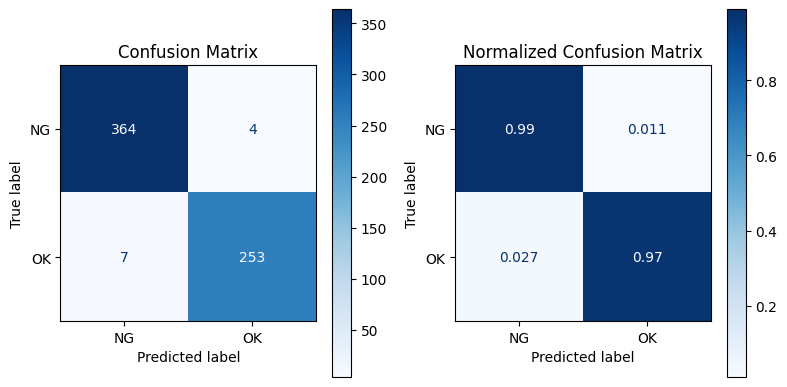

In [105]:
# 테스트 데이터에 대한 예측 생성
model.eval()  # 모델을 평가 모드로 설정
all_predictions = []
all_targets = []

with torch.no_grad():  # 그래디언트 계산을 비활성화
    for images, targets in test_loader:
        images, targets = images.to(DEVICE), targets.to(DEVICE)
        outputs = model(images)

        # 예측 결과 생성 (여기서 sigmoid를 사용하여 확률로 변환)
        predicted = (torch.sigmoid(outputs.view(-1)) > 0.5).float()  # 이진 분류 기준으로 확률 임계값 설정

        all_predictions.extend(predicted.cpu().numpy())  # 예측 결과 저장
        all_targets.extend(targets.cpu().numpy())  # 실제 레이블 저장

# 리스트를 numpy 배열로 변환
all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

# 평가 함수 호출
get_evaluation(all_targets, all_predictions)

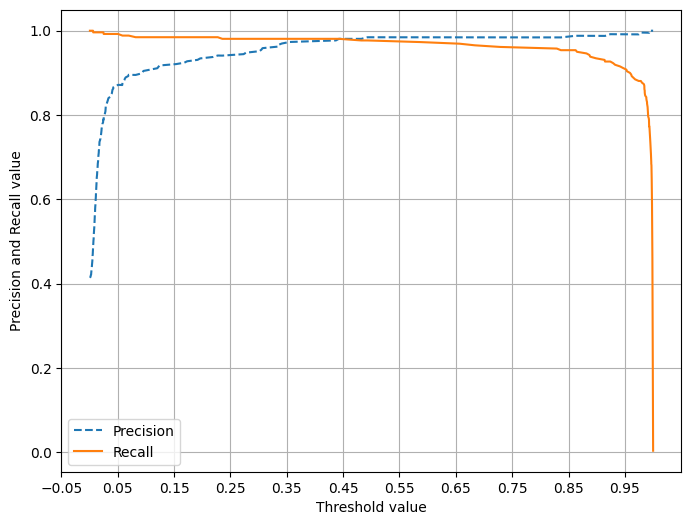

In [106]:
# 테스트 데이터에 대한 예측 확률 생성
model.eval()  # 모델을 평가 모드로 설정
all_predictions_proba = []

with torch.no_grad():  # 그래디언트 계산을 비활성화
    for images, targets in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        
        # 예측 확률 생성 (여기서 sigmoid를 사용하여 확률로 변환)
        predicted_proba = torch.sigmoid(outputs.view(-1)).cpu().numpy()
        all_predictions_proba.extend(predicted_proba)

# 리스트를 numpy 배열로 변환
all_predictions_proba = np.array(all_predictions_proba)

# 테스트 데이터의 실제 레이블 수집
all_targets = []
for images, targets in test_loader:
    all_targets.extend(targets.numpy())  # flatten을 위한 리스트에 추가
all_targets = np.array(all_targets)  # 리스트를 numpy 배열로 변환

# 정밀도-재현율 곡선 그리기
precision_recall_curve_plot(all_targets, all_predictions_proba)

In [107]:
# 예측 확률과 타겟 값 가져오기
all_predictions_proba, all_targets = get_predictions_proba(model, test_loader)

# 정밀도-재현율 곡선과 임계값 계산
precisions, recalls, thresholds = precision_recall_curve(all_targets, all_predictions_proba)

# 임계값 확인
print(thresholds)

[8.06140073e-04 1.14399649e-03 1.35667622e-03 1.74668722e-03
 1.89656171e-03 2.06162478e-03 2.27106269e-03 2.30855588e-03
 2.32703285e-03 2.43111048e-03 2.50099576e-03 2.89768307e-03
 2.96363584e-03 2.96906545e-03 2.99236504e-03 3.03059840e-03
 3.09269410e-03 3.13218310e-03 3.14488471e-03 3.22605669e-03
 3.26531171e-03 3.33228731e-03 3.36141349e-03 3.47132725e-03
 3.50434752e-03 3.53167835e-03 3.62732681e-03 3.74748139e-03
 3.86166270e-03 3.89325572e-03 3.95150715e-03 4.00209846e-03
 4.06096270e-03 4.13176790e-03 4.19558445e-03 4.20702528e-03
 4.31030430e-03 4.33860673e-03 4.33868682e-03 4.35010949e-03
 4.35835961e-03 4.41657472e-03 4.46380023e-03 4.48205462e-03
 4.59322007e-03 4.60672658e-03 4.61996300e-03 4.63301269e-03
 4.66076517e-03 4.70688427e-03 4.82680043e-03 4.90889139e-03
 5.00610936e-03 5.09339385e-03 5.10674017e-03 5.11032669e-03
 5.12915943e-03 5.14578540e-03 5.15751867e-03 5.16933668e-03
 5.20326290e-03 5.22044953e-03 5.22107445e-03 5.22830058e-03
 5.24009438e-03 5.285065

In [108]:
# 테스트 데이터에 대한 예측 확률을 계산
model.eval()  # 모델을 평가 모드로 설정
all_predictions_proba = []

with torch.no_grad():  # 그래디언트 계산을 비활성화
    for images, targets in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        
        # 예측 확률 생성 (여기서 sigmoid를 사용하여 확률로 변환)
        predicted_proba = torch.sigmoid(outputs.view(-1)).cpu().numpy()
        all_predictions_proba.extend(predicted_proba)

# 리스트를 numpy 배열로 변환
all_predictions_proba = np.array(all_predictions_proba)

# 테스트 데이터의 실제 레이블 수집
all_targets = []
for images, targets in test_loader:
    all_targets.extend(targets.numpy())  # flatten을 위한 리스트에 추가
all_targets = np.array(all_targets)  # 리스트를 numpy 배열로 변환

# 임계값에 따른 평가 수행
get_evaluation_by_thresholds(all_targets, all_predictions_proba.reshape(-1, 1), thresholds)

임곗값: 0.0008061401
오차 행렬
[[  1 367]
 [  0 260]]
정확도: 0.4156, 정밀도: 0.4147, 재현율: 1.0000, F1:0.5862, AUC:0.5014
###########################################################################
임곗값: 0.0011439965
오차 행렬
[[  2 366]
 [  0 260]]
정확도: 0.4172, 정밀도: 0.4153, 재현율: 1.0000, F1:0.5869, AUC:0.5027
###########################################################################
임곗값: 0.0013566762
오차 행렬
[[  3 365]
 [  0 260]]
정확도: 0.4188, 정밀도: 0.4160, 재현율: 1.0000, F1:0.5876, AUC:0.5041
###########################################################################
임곗값: 0.0017466872
오차 행렬
[[  4 364]
 [  0 260]]
정확도: 0.4204, 정밀도: 0.4167, 재현율: 1.0000, F1:0.5882, AUC:0.5054
###########################################################################
임곗값: 0.0018965617
오차 행렬
[[  5 363]
 [  0 260]]
정확도: 0.4220, 정밀도: 0.4173, 재현율: 1.0000, F1:0.5889, AUC:0.5068
###########################################################################
임곗값: 0.0020616248
오차 행렬
[[  6 362]
 [  0 260]]
정확도: 0.4236, 정밀도: 0.4180, 재현율: 1.

d:\isy\test\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


오차 행렬
[[364   4]
 [  6 254]]
정확도: 0.9841, 정밀도: 0.9845, 재현율: 0.9769, F1: 0.9807, ROC-AUC: 0.9830
################################################################################


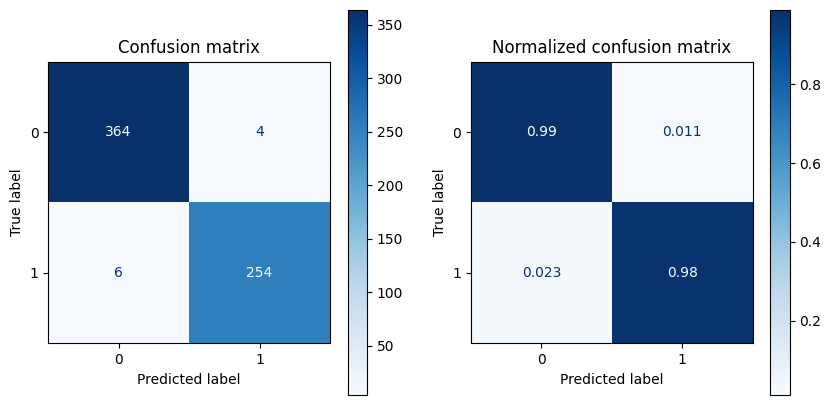

In [110]:
# 예측 확률과 타겟 값 가져오기
all_predictions_proba, all_targets = get_predictions_proba(model, test_loader)

# 임계값 설정 및 이진 분류
threshold = 0.48228806
binarizer = Binarizer(threshold=threshold)
custom_prediction = binarizer.fit_transform(all_predictions_proba.reshape(-1, 1)).flatten()

# 평가 함수 호출
get_evaluation_by_custom_proba(all_targets, custom_prediction, visualize=True)

In [182]:
import os
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np

# 이미지 증강을 위한 transform 설정 (회전, 좌우반전, 밝기 조정 등)
aug = A.Compose([
    A.HorizontalFlip(p=0.5),                # 좌우 반전
    A.VerticalFlip(p=0.5),                  # 상하 반전
    A.Rotate(limit=90, p=0.5),              # 작은 각도 회전 (10도 내외)
    A.RandomBrightnessContrast(p=0.5),      # 밝기 및 대비 조절
    ToTensorV2()
])

# 소수 클래스가 포함된 클래스 목록
minority_classes = ['nogwang', 'bichim', 'Island', 'chui', 'pyomyun']
input_dir = "../PCB_imgs/all/resize/NG/"  # NG 폴더 경로
output_dir = "../PCB_imgs/minority_augmented/"  # 증강된 이미지 저장 경로

os.makedirs(output_dir, exist_ok=True)

# NG 폴더 내에서 소수 클래스 이미지 필터링 및 증강
for img_file in os.listdir(input_dir):
    img_path = os.path.join(input_dir, img_file)
    
    # 이미지 파일명이 소수 클래스명을 포함하는지 확인
    for cls in minority_classes:
        if cls.lower() in img_file.lower():  # 파일명에 클래스명이 포함되면
            os.makedirs(output_dir, exist_ok=True)
            
            img = Image.open(img_path)
            img_np = np.array(img)  # Image 객체를 numpy 배열로 변환
            
            # 증강 이미지 생성 및 저장 (10개 생성)
            for i in range(10):
                augmented = aug(image=img_np)
                augmented_img = augmented['image'].permute(1, 2, 0).numpy()  # tensor를 numpy로 변환
                augmented_img_pil = Image.fromarray(np.uint8(augmented_img))  # PIL 이미지로 변환
                augmented_img_pil.save(os.path.join(output_dir, f"{os.path.splitext(img_file)[0]}_aug_{i}.png"))

In [186]:
import os
import torch
import torchvision.transforms as transforms
from PIL import Image
import torch.nn as nn

# 모델이 GPU에 있으면 GPU로, CPU에 있으면 CPU로 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# 평가 모드로 전환
model.eval()

# 데이터 변환 정의 (이미지 전처리)
transform = transforms.Compose([
    transforms.Resize((260, 260)),  # 이미지 크기 조정
    transforms.ToTensor(),  # 이미지를 Tensor로 변환
])

# 이미지 경로
image_dir = '../PCB_imgs/minority_augmented/'

# 이미지 파일 경로 리스트
image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(('.png'))]

# 예측 수행
with torch.no_grad():  # 그래디언트 계산 비활성화
    for img_path in image_files:
        # 이미지 로드 및 변환
        img = Image.open(img_path).convert('RGB')  # 이미지를 RGB로 변환
        img = transform(img).unsqueeze(0).to(device)  # 배치 차원 추가하고 GPU로 이동
        
        # 모델 예측
        outputs = model(img)
        
        # Sigmoid를 적용하여 확률로 변환
        outputs = torch.sigmoid(outputs)
        
        # 예측값을 0 또는 1로 변환
        predicted = (outputs >= 0.5).float()
        
        # 예측 결과 출력
        result = 'NG' if predicted.item() == 1 else 'OK'
        print(f'Image: {img_path}, Prediction: {result}')

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


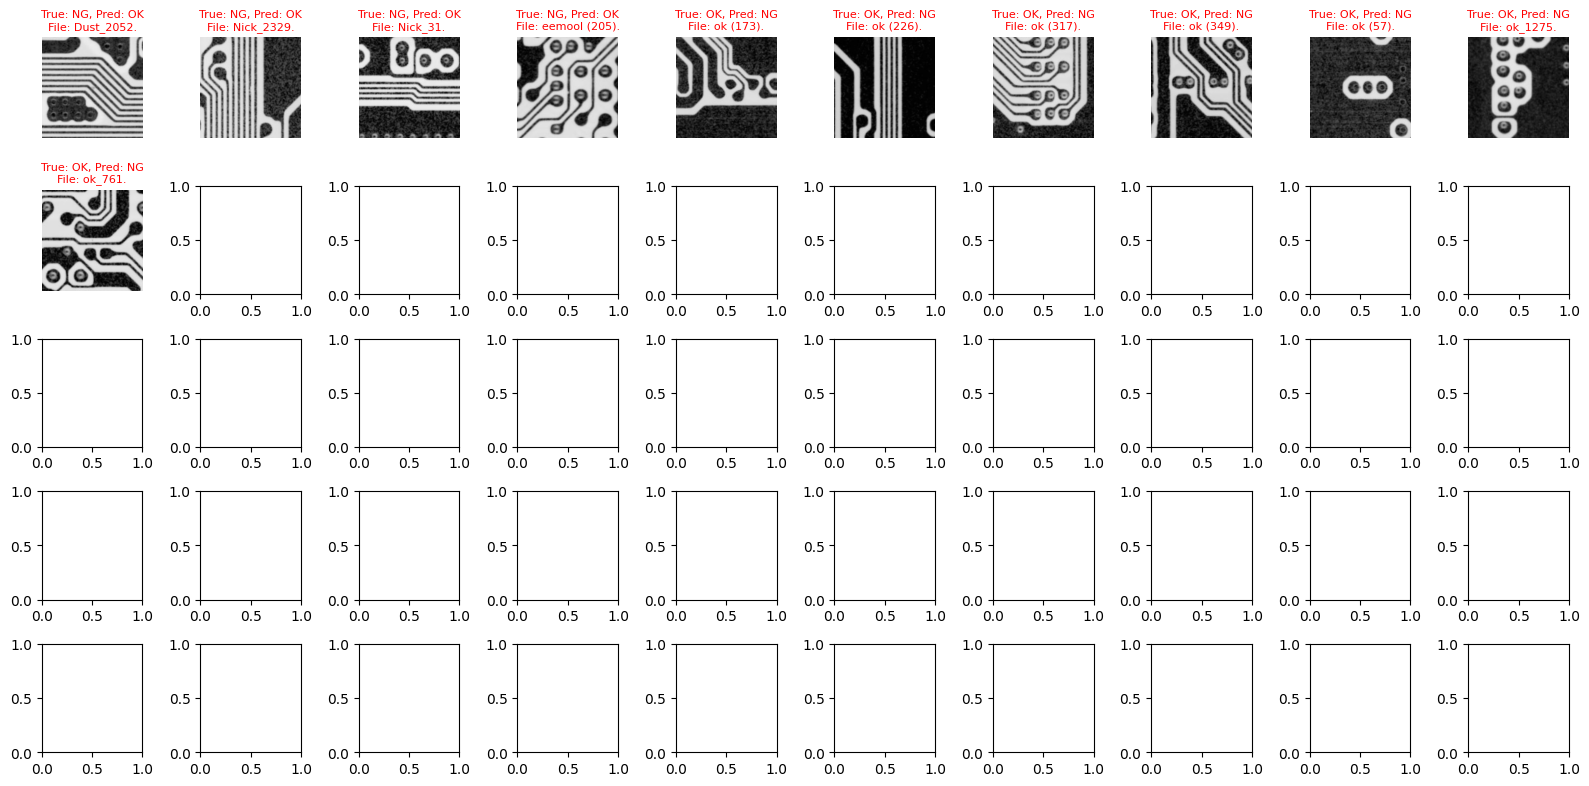

In [140]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# 테스트 데이터셋에서 예측이 틀린 샘플을 선택하는 함수
def get_incorrect_samples(model, dataset, num_samples=50):
    incorrect_samples = []
    
    model.eval()  # 모델을 평가 모드로 전환
    with torch.no_grad():
        for i in range(len(dataset)):
            image, label, file_path = dataset[i]
            image_input = image.unsqueeze(0).to(DEVICE)  # 배치 차원 추가 및 장치로 이동
            
            # 예측 수행
            output = model(image_input)
            pred = torch.sigmoid(output).item()
            pred_label = 1 if pred > 0.5 else 0
            
            # 정답이 아닌 경우 추가
            if pred_label != label:
                incorrect_samples.append((image, label, pred_label, file_path))
                if len(incorrect_samples) >= num_samples:  # 원하는 수의 샘플을 가져왔을 경우
                    break
    
    return incorrect_samples

# 이미지 시각화 및 예측 결과 표시 (오답만)
def visualize_incorrect_predictions(model, dataset, num_samples=50):
    # 틀린 샘플 가져오기
    samples = get_incorrect_samples(model, dataset, num_samples)
    
    if not samples:
        print("No incorrect predictions found.")
        return

    fig, axs = plt.subplots(5, num_samples // 5, figsize=(16, 8)) 
    axs = axs.ravel()
    
    for i, (image, label, pred_label, file_path) in enumerate(samples):
        # 이미지를 numpy로 변환하여 시각화
        image_np = image.cpu().numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
        image_np = (image_np * 255).astype(np.uint8)  # [0, 1] 범위에서 [0, 255] 범위로 변환
        
        # 정답/오답에 따른 레이블 색상 결정
        color = 'red'  # 모든 틀린 예측은 빨간색
        
        label_name = 'NG' if label == 0 else 'OK'
        pred_label_name = 'NG' if pred_label == 0 else 'OK'

        # 이미지 및 레이블 출력
        axs[i].imshow(image_np)
        axs[i].set_title(f"True: {label_name}, Pred: {pred_label_name}\nFile: {file_path[31:-7]}", color=color, fontsize=8)
        axs[i].axis('off')  # 축 제거
    
    plt.tight_layout()
    plt.show()

# 모델을 사용하여 테스트 데이터에서 틀린 샘플 예측 및 시각화
visualize_incorrect_predictions(model, test_dataset)